Connected to MetaTrader 5


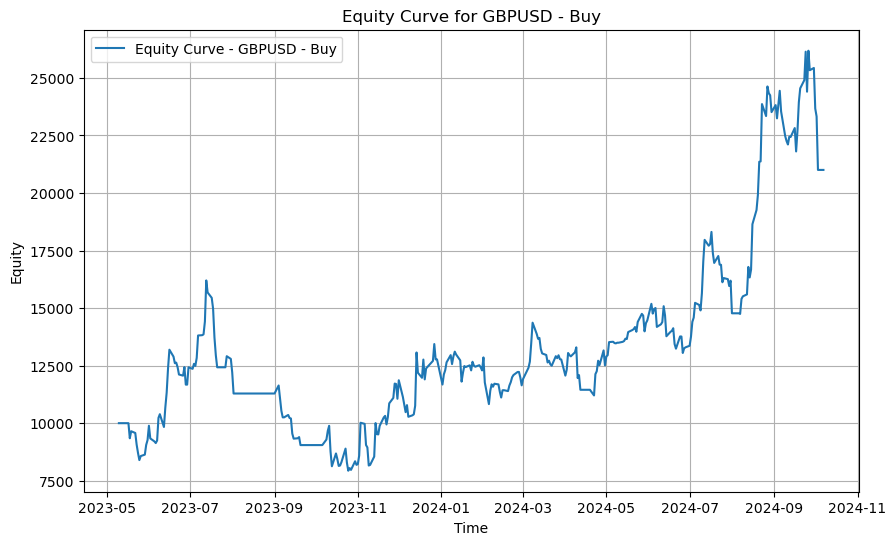

Backtest results for GBPUSD - Buy:
 Start                     2023-05-10 00:00:00
End                       2024-10-07 00:00:00
Duration                    516 days 00:00:00
Exposure Time [%]                   84.741144
Equity Final [$]                 21001.735762
Equity Peak [$]                  26180.135576
Return [%]                         110.017358
Buy & Hold Return [%]                3.626225
Return (Ann.) [%]                   66.447027
Volatility (Ann.) [%]              118.565162
Sharpe Ratio                         0.560426
Sortino Ratio                        1.643373
Calmar Ratio                         1.302222
Max. Drawdown [%]                  -51.025901
Avg. Drawdown [%]                   -14.48717
Max. Drawdown Duration      364 days 00:00:00
Avg. Drawdown Duration       49 days 00:00:00
# Trades                                   68
Win Rate [%]                        51.470588
Best Trade [%]                       1.986758
Worst Trade [%]                     -1.17484

In [1]:
import pandas as pd
import MetaTrader5 as mt5
from backtesting import Backtest, Strategy
import logging
from datetime import datetime
import pytz
import matplotlib.pyplot as plt

# Logging configuration
#logging.basicConfig(filename='backtest.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# MetaTrader 5 initialization
def init_mt5_connection(login, password, server):
    if not mt5.initialize(login=login, password=password, server=server):
        logging.error(f"initialize() failed, error code = {mt5.last_error()}")
        sys.exit()
    logging.info("Connected to MetaTrader 5")
    print("Connected to MetaTrader 5")

# Fetch historical OHLC data from MetaTrader 5
def fetch_ohlc_data(symbol, timeframe, start_date, end_date):
    data = mt5.copy_rates_range(symbol, timeframe, start_date, end_date)
    if data is None or len(data) == 0:
        logging.error(f"Failed to fetch data for {symbol}")
        return None
    ohlc_data = pd.DataFrame(data)
    ohlc_data['time'] = pd.to_datetime(ohlc_data['time'], unit='s')
    ohlc_data.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'tick_volume': 'Volume'}, inplace=True)
    return ohlc_data[['time', 'Open', 'High', 'Low', 'Close', 'Volume']]  # Include Volume

# Load and align prediction data
def load_and_align_data(ohlc_data, prediction_file):
    try:
        predictions = pd.read_csv(prediction_file, parse_dates=['time'])
        if 'prediction' not in predictions.columns:
            logging.error(f"'prediction' column not found in {prediction_file}")
            return None
    except Exception as e:
        logging.error(f"Error loading prediction file: {e}")
        return None
    # Merge predictions with OHLC data
    ohlc_data = ohlc_data.merge(predictions[['time', 'prediction']], on='time', how='left')
    ohlc_data['prediction'] = ohlc_data['prediction'].fillna(0)  # Fill missing predictions with 0
    ohlc_data['prediction'] = ohlc_data['prediction'].shift(1)  # Shift predictions to next date
    return ohlc_data

# Backtesting strategy for Buy or Sell
class PredictionStrategy(Strategy):
    risk_reward_ratio = (2, 3)  # Default risk-reward ratio
    signal_type = 'Buy'  # Default signal type
    mean_candle_size = 0.0105  # Default mean candle size

    def init(self):
        # Mean candle size now taken from strategy properties set during strategy initialization
        pass

    def next(self):
        entry_price = self.data.Close[-1]
        risk_part, reward_part = self.risk_reward_ratio
        # Buy signal
        if self.data.prediction[-1] == 1 and self.signal_type == 'Buy':
            sl_price = entry_price - self.mean_candle_size * risk_part
            tp_price = entry_price + self.mean_candle_size * reward_part
            self.buy(sl=sl_price, tp=tp_price)
        # Sell signal
        elif self.data.prediction[-1] == 1 and self.signal_type == 'Sell':
            sl_price = entry_price + self.mean_candle_size * risk_part
            tp_price = entry_price - self.mean_candle_size * reward_part
            self.sell(sl=sl_price, tp=tp_price)

# Function to perform backtesting and save stats/plot
# Function to perform backtesting and save stats/plot
def run_backtest(ohlc_data, strategy_class, risk_reward_ratio, pair_name, signal_type, mean_candle_size):
    strategy_class.risk_reward_ratio = risk_reward_ratio
    strategy_class.signal_type = signal_type
    strategy_class.mean_candle_size = mean_candle_size  # Set mean candle size for the strategy
    
    # Run the backtest
    bt = Backtest(ohlc_data.set_index('time'), strategy_class, cash=10000, commission=.0003, margin=.1)
    stats = bt.run()
    
    # Plot the equity curve
    equity_curve = stats['_equity_curve']['Equity']
    
    plt.figure(figsize=(10, 6))
    plt.plot(equity_curve, label=f'Equity Curve - {pair_name} - {signal_type}')
    plt.title(f'Equity Curve for {pair_name} - {signal_type}')
    plt.xlabel('Time')
    plt.ylabel('Equity')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return stats


# Main function to fetch OHLC data, align it with prediction data, and run backtest for each buy/sell
def main():
    config = {
        'login': 51988090,
        'password': '1fMdV52$74EOcw',
        'server': 'ICMarketsEU-Demo',
        'GBPUSD': {
            'symbol': 'GBPUSD',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.011266204280682732,
            'buy_prediction_file': 'predGBPUSD_D1_3112buy.csv',
            'buy_risk_reward_ratio': (1, 2),
        }
    }

    init_mt5_connection(config['login'], config['password'], config['server'])
    utc_from = datetime(2023, 5, 10, tzinfo=pytz.utc)
    utc_to = datetime(2024, 10, 7, tzinfo=pytz.utc)

    for pair_name, pair_config in config.items():
        if pair_name in ['login', 'password', 'server']:
            continue
        logging.info(f"Processing {pair_name}...")
        ohlc_data = fetch_ohlc_data(pair_config['symbol'], pair_config['timeframe'], utc_from, utc_to)
        if ohlc_data is None:
            continue

        if pair_config['buy_prediction_file']:
            ohlc_data_with_predictions = load_and_align_data(ohlc_data, pair_config['buy_prediction_file'])
            if ohlc_data_with_predictions is not None:
                stats = run_backtest(ohlc_data_with_predictions, PredictionStrategy, pair_config['buy_risk_reward_ratio'], pair_name, 'Buy', pair_config['mean_candle_size'])
                print(f"Backtest results for {pair_name} - Buy:\n", stats)
        if pair_config.get('sell_prediction_file'):
            ohlc_data_with_predictions = load_and_align_data(ohlc_data, pair_config['sell_prediction_file'])
            if ohlc_data_with_predictions is not None:
                stats = run_backtest(ohlc_data_with_predictions, PredictionStrategy, pair_config['sell_risk_reward_ratio'], pair_name, 'Sell', pair_config['mean_candle_size'])
                print(f"Backtest results for {pair_name} - Sell:\n", stats)

    mt5.shutdown()

if __name__ == "__main__":
    main()


Connected to MetaTrader 5


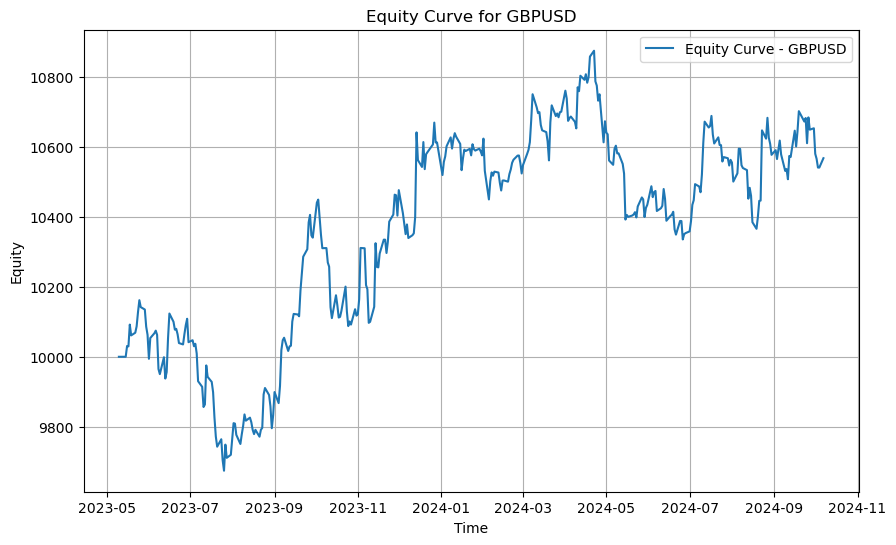

Backtest results for GBPUSD - Combined Buy and Sell:
 Start                     2023-05-10 00:00:00
End                       2024-10-07 00:00:00
Duration                    516 days 00:00:00
Exposure Time [%]                   98.637602
Equity Final [$]                 10567.269988
Equity Peak [$]                  10874.265177
Return [%]                             5.6727
Buy & Hold Return [%]                3.626225
Return (Ann.) [%]                    3.861364
Volatility (Ann.) [%]                7.389434
Sharpe Ratio                         0.522552
Sortino Ratio                        0.844544
Calmar Ratio                         0.778941
Max. Drawdown [%]                   -4.957195
Avg. Drawdown [%]                   -1.484786
Max. Drawdown Duration      168 days 00:00:00
Avg. Drawdown Duration       34 days 00:00:00
# Trades                                   81
Win Rate [%]                        45.679012
Best Trade [%]                       1.840256
Worst Trade [%]           

In [4]:
import pandas as pd
import MetaTrader5 as mt5
from backtesting import Backtest, Strategy
import logging
from datetime import datetime
import pytz
import matplotlib.pyplot as plt

# Logging configuration
#logging.basicConfig(filename='backtest.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# MetaTrader 5 initialization
def init_mt5_connection(login, password, server):
    if not mt5.initialize(login=login, password=password, server=server):
        logging.error(f"initialize() failed, error code = {mt5.last_error()}")
        sys.exit()
    logging.info("Connected to MetaTrader 5")
    print("Connected to MetaTrader 5")

# Fetch historical OHLC data from MetaTrader 5
def fetch_ohlc_data(symbol, timeframe, start_date, end_date):
    data = mt5.copy_rates_range(symbol, timeframe, start_date, end_date)
    if data is None or len(data) == 0:
        logging.error(f"Failed to fetch data for {symbol}")
        return None
    ohlc_data = pd.DataFrame(data)
    ohlc_data['time'] = pd.to_datetime(ohlc_data['time'], unit='s')
    ohlc_data.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'tick_volume': 'Volume'}, inplace=True)
    return ohlc_data[['time', 'Open', 'High', 'Low', 'Close', 'Volume']]  # Include Volume

# Load and align prediction data
def load_and_align_data(ohlc_data, prediction_file):
    try:
        predictions = pd.read_csv(prediction_file, parse_dates=['time'])
        if 'prediction' not in predictions.columns:
            logging.error(f"'prediction' column not found in {prediction_file}")
            return None
    except Exception as e:
        logging.error(f"Error loading prediction file: {e}")
        return None
    # Merge predictions with OHLC data
    ohlc_data = ohlc_data.merge(predictions[['time', 'prediction']], on='time', how='left')
    ohlc_data['prediction'] = ohlc_data['prediction'].fillna(0)  # Fill missing predictions with 0
    ohlc_data['prediction'] = ohlc_data['prediction'].shift(1)  # Shift predictions to next date
    return ohlc_data

# Backtesting strategy for Buy or Sell
class PredictionStrategy(Strategy):
    buy_margin = 0.04  # Default margin for buy trades
    sell_margin = 0.4  # Default margin for sell trades
    risk_reward_ratio = (2, 3)  # Default risk-reward ratio
    mean_candle_size = 0.0105  # Default mean candle size

    def init(self):
        pass

    def next(self):
        entry_price = self.data.Close[-1]
        risk_part, reward_part = self.risk_reward_ratio
        prediction_signal = self.data.prediction[-1]

        # Buy signal
        if prediction_signal == 1:  # Buy signal
            sl_price = entry_price - self.mean_candle_size * risk_part
            tp_price = entry_price + self.mean_candle_size * reward_part
            self.buy(sl=sl_price, tp=tp_price)  # Framework handles size automatically
        
        # Sell signal
        elif prediction_signal == -1:  # Sell signal
            sl_price = entry_price + self.mean_candle_size * risk_part
            tp_price = entry_price - self.mean_candle_size * reward_part
            self.sell(sl=sl_price, tp=tp_price)  # Framework handles size automatically


""" def run_backtest(ohlc_data, strategy_class, risk_reward_ratio, pair_name, mean_candle_size, buy_margin, sell_margin):
    # Set the strategy parameters
    strategy_class.risk_reward_ratio = risk_reward_ratio
    strategy_class.mean_candle_size = mean_candle_size
    strategy_class.buy_margin = buy_margin  # Set buy margin
    strategy_class.sell_margin = sell_margin  # Set sell margin

    bt = Backtest(ohlc_data.set_index('time'), strategy_class, cash=10000, commission=.0003)
    
    # Run the backtest and display the plot and stats
    stats = bt.run()
    plt.figure(figsize=(10, 6))
    bt.plot()  # Plot both Buy and Sell trades on the same plot
    plt.title(f'Backtest for {pair_name} - Buy and Sell with Different Margins')
    plt.show()  # Show the combined plot
    stats_df = pd.DataFrame([stats])
    return stats """

# Function to perform backtesting and save stats/plot
def run_backtest(ohlc_data, strategy_class, risk_reward_ratio, pair_name, mean_candle_size):
    strategy_class.risk_reward_ratio = risk_reward_ratio
    strategy_class.mean_candle_size = mean_candle_size  # Set mean candle size for the strategy
    
    # Run the backtest
    bt = Backtest(ohlc_data.set_index('time'), strategy_class, cash=10000, commission=.0003)
    stats = bt.run()
    
    # Plot the equity curve
    equity_curve = stats['_equity_curve']['Equity']
    
    plt.figure(figsize=(10, 6))
    plt.plot(equity_curve, label=f'Equity Curve - {pair_name}')
    plt.title(f'Equity Curve for {pair_name}')
    plt.xlabel('Time')
    plt.ylabel('Equity')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return stats

# Main function to fetch OHLC data, align it with combined buy/sell prediction data, and run backtest
def main():
    config = {
        'login': 51988090,
        'password': '1fMdV52$74EOcw',
        'server': 'ICMarketsEU-Demo',
        'GBPUSD': {
            'symbol': 'GBPUSD',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.011266204280682732,
            'buy_prediction_file': 'predGBPUSD_D1_3112buy.csv',
            'buy_risk_reward_ratio': (1, 2),
            'sell_prediction_file': 'predGBPUSD_D1_3112sell.csv',
            'sell_risk_reward_ratio': (1, 1),
            'buy_margin': 0.04,
            'sell_margin': 0.4
        }
    }

    init_mt5_connection(config['login'], config['password'], config['server'])
    utc_from = datetime(2023, 5, 10, tzinfo=pytz.utc)
    utc_to = datetime(2024, 10, 7, tzinfo=pytz.utc)

    for pair_name, pair_config in config.items():
        if pair_name in ['login', 'password', 'server']:
            continue
        logging.info(f"Processing {pair_name}...")
        ohlc_data = fetch_ohlc_data(pair_config['symbol'], pair_config['timeframe'], utc_from, utc_to)
        if ohlc_data is None:
            continue

        # Load Buy predictions and merge
        buy_predictions = load_and_align_data(ohlc_data, pair_config['buy_prediction_file'])
        if buy_predictions is not None:
            buy_predictions['prediction'] = buy_predictions['prediction'].apply(lambda x: 1 if x == 1 else 0)  # Mark buy as 1

        # Load Sell predictions and merge
        sell_predictions = load_and_align_data(ohlc_data, pair_config['sell_prediction_file'])
        if sell_predictions is not None:
            sell_predictions['prediction'] = sell_predictions['prediction'].apply(lambda x: -1 if x == 1 else 0)  # Mark sell as -1

        # Combine both Buy and Sell predictions into a single dataset
        if buy_predictions is not None and sell_predictions is not None:
            combined_predictions = buy_predictions[['time', 'prediction']].copy()
            combined_predictions['prediction'] += sell_predictions['prediction']

            # If both Buy and Sell signals exist on the same day, set prediction to 0 (no trade)
            combined_predictions['prediction'] = combined_predictions['prediction'].apply(lambda x: 0 if x == 0 else x)

            ohlc_data_with_predictions = ohlc_data.merge(combined_predictions[['time', 'prediction']], on='time', how='left')
            ohlc_data_with_predictions['prediction'] = ohlc_data_with_predictions['prediction'].fillna(0)  # Fill missing predictions with 0

            # Run combined backtest for both buy and sell
            stats = run_backtest(ohlc_data_with_predictions, PredictionStrategy, pair_config['buy_risk_reward_ratio'], pair_name, pair_config['mean_candle_size'])
            print(f"Backtest results for {pair_name} - Combined Buy and Sell:\n", stats)

    mt5.shutdown()

if __name__ == "__main__":
    main()


In [ ]:

+